# Extract BICEP-Keck instrument parameters

In [1]:
ipac_warning = [
    "Text file in IPAC table format, read with astropy",
    "from astropy.table import QTable",
    "QTable.read('filename.tbl', format='ascii.ipac')",
    f"Instrument model exported from http://bicepkeck.org/bk18_2021_release.html",
]

In [2]:
import numpy as np
from astropy.io import fits

from astropy.table import QTable
from pysm3 import units as u
from pathlib import Path
import healpy as hp
import pandas as pd



In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
for fname in [
    "BK18_B95_bandpass_20210607.txt",
    "BK18_K95_bandpass_20210607.txt",
    "BK18_150_bandpass_20210607.txt",
    "BK18_220_bandpass_20210607.txt",
]:
    file_path = Path(fname)
    if not file_path.exists():
        !wget http://bicepkeck.org/BK18_datarelease/{fname}

In [5]:
channels = [fname.split('_')[1] for fname in [
    "BK18_B95_bandpass_20210607.txt",
    "BK18_K95_bandpass_20210607.txt",
    "BK18_150_bandpass_20210607.txt",
    "BK18_220_bandpass_20210607.txt",
]]

In [6]:
channels

['B95', 'K95', '150', '220']

In [7]:
bandpasses = {}
for fname, channel in zip([
    "BK18_B95_bandpass_20210607.txt",
    "BK18_K95_bandpass_20210607.txt",
    "BK18_150_bandpass_20210607.txt",
    "BK18_220_bandpass_20210607.txt",
], channels):
    df = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, names=['freq', 'power', 'RJ'])
    # Normalize so that the area under the curve is 1
    norm = np.trapz(df["power"].values, df["freq"].values)
    df["power"] = df["power"] / norm
    df.loc[df["power"] < 0, "power"] = 0
    bandpasses[channel] = df

/tmp/ipykernel_349030/63189863.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, names=['freq', 'power', 'RJ'])
/tmp/ipykernel_349030/63189863.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, names=['freq', 'power', 'RJ'])
/tmp/ipykernel_349030/63189863.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, names=['freq', 'power', 'RJ'])
/tmp/ipykernel_349030/63189863.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future v

In [8]:
from collections import OrderedDict
from astropy import units as u
from astropy.table import QTable

In [9]:
table = QTable(
    names=[
        "telescope",
        "band",
        "center_frequency",
        "fwhm",
        "nside",
        "bandpass_file",
        "beam_file",
    ],
    dtype=[str, str, float, float, int, str, str],
    units=[None, None, u.GHz, u.arcmin, None, None, None],
)

In [10]:
fwhms = {
    "B95": 24 * u.arcmin,   # 95 GHz (BICEP)
    "K95": 43 * u.arcmin,   # 95 GHz (Keck)
    "150": 30 * u.arcmin,   # 150 GHz
    "220": 20 * u.arcmin    # 220 GHz
}

In [11]:
nside = 1024
hp.nside2resol(nside, arcmin=True)

3.435486411817406

In [12]:
for label in channels:
        bp = bandpasses[label]
        center_frequency = float(''.join(filter(str.isdigit, label))) * u.GHz
        table.add_row(
            OrderedDict(
                telescope="BK18",
                band=label,
                center_frequency=center_frequency,
                fwhm=fwhms[label],
                nside=nside,
                bandpass_file="bandpass_" + label + ".tbl",
            )
        )

In [13]:
table

telescope,band,center_frequency,fwhm,nside,bandpass_file,beam_file
,,GHz,arcmin,,,
str4,str3,float64,float64,int64,str16,str1
BK18,B95,95.0,24.0,1024,bandpass_B95.tbl,
BK18,K95,95.0,43.0,1024,bandpass_K95.tbl,
BK18,150,150.0,30.0,1024,bandpass_150.tbl,
BK18,220,220.0,20.0,1024,bandpass_220.tbl,


In [14]:
table.meta["comments"] = ipac_warning
table.write(f"instrument_model.tbl", format="ascii.ipac", overwrite=True)

## Create bandpass files

In [15]:
for label, df in bandpasses.items():
    # Normalize so that the area under the curve is 1
    qtable = QTable(
        names=["bandpass_frequency", "bandpass_weight"],
        units=[u.GHz, None],
        data=[df["freq"].values * u.GHz, df["power"].values ],
    )
    qtable.meta["comments"] = ipac_warning
    qtable.write(f"bandpass_{label}.tbl", format="ascii.ipac", overwrite=True)

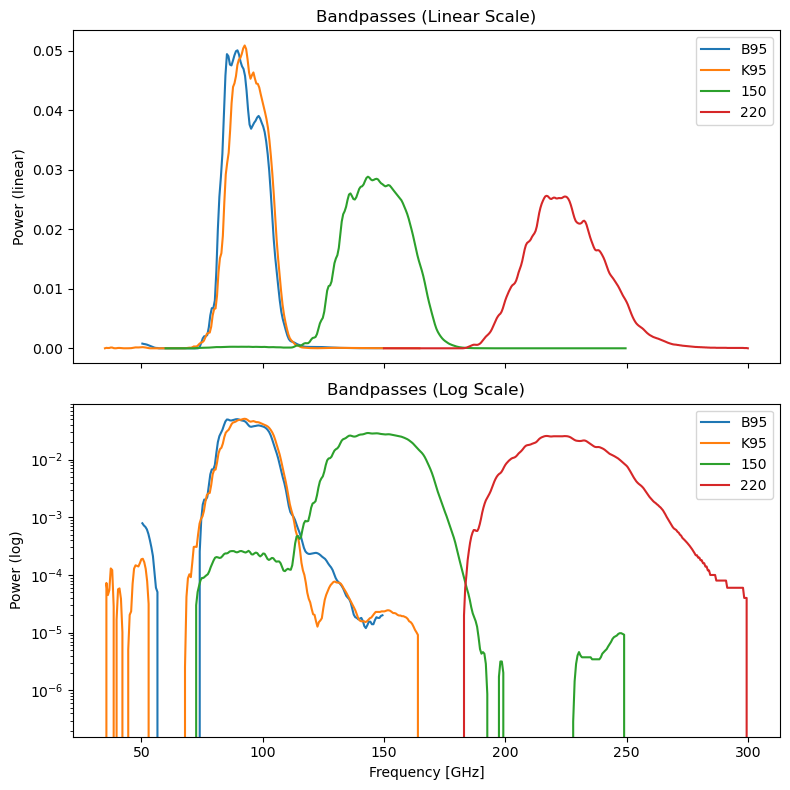

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

for label in channels:
    df = bandpasses[label]
    axes[0].plot(df['freq'], df['power'], label=label)
    axes[1].semilogy(df['freq'], df['power'], label=label)

axes[0].set_ylabel('Power (linear)')
axes[0].legend()
axes[0].set_title('Bandpasses (Linear Scale)')

axes[1].set_xlabel('Frequency [GHz]')
axes[1].set_ylabel('Power (log)')
axes[1].legend()
axes[1].set_title('Bandpasses (Log Scale)')

plt.tight_layout()
plt.show()